In [22]:
import pandas as pd
import json
import requests
import re
import string
import feather

import matplotlib.pyplot as plt
%matplotlib inline

# How long to beat offers average playing times for most games
# https://github.com/ScrappyCocco/HowLongToBeat-PythonAPI
from howlongtobeatpy import HowLongToBeat

# Building a game database

## Importing the data

We have the data in a Numbers spreadsheet which we exported to csv using the default settings, ie an UTF-8 encoding and a ";" as separator. We will use Pandas to import the data because it offers a very extensive CSV import. Besides, a Pandas dataframe is basically a spreadsheet and we can use extremely powerful functionality on it. The downside is that it is not very performant. Another thing is that we will have to use a lot of functionality not really well integrated into Pandas for handling JSON data.

We stat by importing the data into the dataframe, which is nice and short in Pandas.

In [3]:
psn_games = pd.read_csv("Playstation_Spiele.csv", sep=";")

psn_games

,web-scraper-order,web-scraper-start-url,game_title,game_details,game_platforms,game_flag
0,1591029098-1000,https://store.playstation.com/de-de/download/list,Rayman® Legends,Spiel | 9.03 GB | 1/5/2018,PS4,NaN
1,1591029098-1001,https://store.playstation.com/de-de/download/list,A KING'S TALE: FINAL FANTASY XV,Spiel | 2.05 GB | 27/4/2018,PS4,NaN
2,1591029098-1002,https://store.playstation.com/de-de/download/list,Mad Max,Spiel | 33.2 GB | 8/4/2018,PS4,NaN
3,1591029098-1003,https://store.playstation.com/de-de/download/list,In Space We Brawl,Spiel | 238.81 MB | 8/4/2018,PS4,NaN
4,1591029098-1004,https://store.playstation.com/de-de/download/list,Mad Max: The Road Warrior Pack,Extra | 26.8 MB | 8/4/2018,PS4,0.0
...,...,...,...,...,...,...
1082,NaN,NaN,NaN,NaN,NaN,NaN
1083,NaN,NaN,GreedFall,NaN,PS4,NaN
1084,NaN,NaN,NBA 2K20,NaN,PS4,NaN
1085,NaN,NaN,Erica,NaN,PS4,NaN


## Preparing the data

When scraping the data from the Playstation Network we got a string with three elements. We split them which is also concise and short in Pandas. We do the same with the web-scraper-order the web scraper in Pandas generated. We will get NaNs in both operations because I added some games manually, just filling the name and the game platforms.

In [4]:
df_tmp = psn_games["game_details"].str.split("|", expand=True)

psn_games["game_category"] = df_tmp[0]
psn_games["game_size"] = df_tmp[1]
psn_games["game_buy_date"] = df_tmp[2]
psn_games.drop(columns=("game_details"), inplace=True)

df_tmp = psn_games["web-scraper-order"].str.split("-", expand=True)
psn_games["web-scraper-order"] = df_tmp[1]
psn_games.drop(columns=("web-scraper-start-url"), inplace=True)

psn_games

,web-scraper-order,game_title,game_platforms,game_flag,game_category,game_size,game_buy_date
0,1000,Rayman® Legends,PS4,NaN,Spiel,9.03 GB,1/5/2018
1,1001,A KING'S TALE: FINAL FANTASY XV,PS4,NaN,Spiel,2.05 GB,27/4/2018
2,1002,Mad Max,PS4,NaN,Spiel,33.2 GB,8/4/2018
3,1003,In Space We Brawl,PS4,NaN,Spiel,238.81 MB,8/4/2018
4,1004,Mad Max: The Road Warrior Pack,PS4,0.0,Extra,26.8 MB,8/4/2018
...,...,...,...,...,...,...,...
1082,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1083,NaN,GreedFall,PS4,NaN,NaN,NaN,NaN
1084,NaN,NBA 2K20,PS4,NaN,NaN,NaN,NaN
1085,NaN,Erica,PS4,NaN,NaN,NaN,NaN


## Augment the data

From the PSN we only got very limited information about the games. We will augment this data using the internet games database, also known as [IGDB](https://www.igdb.com/). The IGDB has a simple to use rest API which is easy to use. It is free for non-commerical use, but you have to register and will get an API key. Just store it in a file as in the code below. You can also copy it directly in the source code, but beware if you make the code available on GitHub or anything else.

The key is always sent in the header. The IGDB rest service use a query language called [Apicalypse](https://apicalypse.io/) and the actual query is sent in the body, both GET and POST requests work. The result is a JSON. There are different endpoints for different objects such as games, platforms, genres, etc. Check the [documentation](https://api-docs.igdb.com/) for more infornation.

First we set up the header with the user key as we will need it for all calls.

In [5]:
# Never check in this file on GitHub!
with open('igdb_user_key.txt', 'r') as file:
    igdb_user_key = file.read()
    
# the user key is in the header. You get it after registering.
igdb_headers = {
    "user-key" : igdb_user_key
}

### Platforms

The next step is that we get the id of the platforms we are interested in. For now we will only look at PS4 games. We will use this ids later in the queries when searching the games to limit the search results. If you try `fields *` you will see that a lot more information is available on platforms. The result is always a JSON which we parse using the `json` library. For some reason we get a list of dictionaries using this API which we convert into a Python dictionary. This we will need later. We search the platforms we are interested in.

We do the same for other objects we are interested in, eg genre. IGBD stores them as object with a variety of attributes. We will only use the names in our database.

In [6]:
igdb_url = "https://api-v3.igdb.com/platforms"

# we get all the platforms with id and name
igdb_data = 'fields id, name; limit 500;'

req = requests.post(igdb_url, data=igdb_data, headers=igdb_headers)

igdb_platforms_list = json.loads(req.content)

# the JSON is a list of dicts which we convert to a dictionary
# this we can later use to map results (which are ids) to strings
igdb_platforms = {}
for elem in igdb_platforms_list:
    igdb_platforms[elem["id"]] = elem["name"]

# we look up the keys (IGDB ids) for the plaforms we are interested in
igdb_id_ps4 = next(key for key, value in igdb_platforms.items() if value == 'PlayStation 4')

igdb_id_ps3 = next(key for key, value in igdb_platforms.items() if value == 'PlayStation 3')

igdb_id_psn = next(key for key, value in igdb_platforms.items() if value == 'PlayStation Network')

print(igdb_id_ps4)


48


In [7]:
igdb_url = "https://api-v3.igdb.com/genres"

# we get all the platforms with id and name
igdb_data = 'fields id, name; limit 500;'

req = requests.post(igdb_url, data=igdb_data, headers=igdb_headers)

igdb_genres_list = json.loads(req.content)

# the JSON is a list of dicts which we convert to a dictionary
# this we can later use to map results (which are ids) to strings
igdb_genres = {}
for elem in igdb_genres_list:
    igdb_genres[elem["id"]] = elem["name"]
    
print(igdb_genres)


{2: 'Point-and-click', 4: 'Fighting', 5: 'Shooter', 7: 'Music', 8: 'Platform', 9: 'Puzzle', 10: 'Racing', 11: 'Real Time Strategy (RTS)', 12: 'Role-playing (RPG)', 13: 'Simulator', 14: 'Sport', 15: 'Strategy', 16: 'Turn-based strategy (TBS)', 24: 'Tactical', 26: 'Quiz/Trivia', 25: "Hack and slash/Beat 'em up", 30: 'Pinball', 31: 'Adventure', 33: 'Arcade', 34: 'Visual Novel', 32: 'Indie', 35: 'Card & Board Game', 36: 'MOBA'}


In [8]:
igdb_url = "https://api-v3.igdb.com/themes"

# we get all the platforms with id and name
igdb_data = 'fields id, name; limit 500;'

req = requests.post(igdb_url, data=igdb_data, headers=igdb_headers)

igdb_themes_list = json.loads(req.content)

# the JSON is a list of dicts which we convert to a dictionary
# this we can later use to map results (which are ids) to strings
igdb_themes = {}
for elem in igdb_themes_list:
    igdb_themes[elem["id"]] = elem["name"]
    
print(igdb_themes)

{20: 'Thriller', 18: 'Science fiction', 1: 'Action', 19: 'Horror', 21: 'Survival', 17: 'Fantasy', 22: 'Historical', 23: 'Stealth', 27: 'Comedy', 28: 'Business', 31: 'Drama', 32: 'Non-fiction', 35: 'Kids', 33: 'Sandbox', 38: 'Open world', 39: 'Warfare', 41: '4X (explore, expand, exploit, and exterminate)', 34: 'Educational', 43: 'Mystery', 40: 'Party', 44: 'Romance', 42: 'Erotic'}


### Covers

The IGDB has a general endpoint for images which is quite powerful as it also includes resizing. This endpoint delivers for example covers or screenshots. For now we are only interested in covers. We query using the game_id retrieving only information about the cover. The relevant inforation is the URL which includes the actual jpeg based on a hasehd image_id.

The resizing we can use by modifxing the t_ part of the URL using the following convention copied from the API decumentation.

Name | Size | Extra
--- | --- | ---
cover_small | 90 x 128 | Fit
screenshot_med | 569 x 320 | Lfill, Center gravity
cover_big | 264 x 374 | Fit
logo_med | 284 x 160 | Fit
screenshot_big | 889 x 500 | Lfill, Center gravity
screenshot_huge | 1280 x 720 | Lfill, Center gravity
thumb | 90 x 90 | Thumb, Center gravity
micro | 35 x 35 | Thumb, Center gravity
720p | 1280 x 720 | Fit, Center gravity
1080p | 1920 x 1080 | Fit, Center gravity

An additional feature is that you can append _2x to get the double size eg for high resolution montors. For now we will store the original URL using the t_thumb format. When delivering the URL to a frontend it can be adapted as required.

In [9]:
igdb_url = "https://api-v3.igdb.com/games"

# we get all the platforms with id and name
# igdb_data = 'fields cover.*; where id=1968;'
igdb_data = 'fields cover.*; where id=100359;'

# igdb_data = 'fields cover.*; where id=134065;'

req = requests.post(igdb_url, data=igdb_data, headers=igdb_headers)

igdb_cover = json.loads(req.content)

print(json.dumps(igdb_cover, indent=4, sort_keys=True))


print(igdb_cover[0]["cover"]["url"])

[
    {
        "cover": {
            "alpha_channel": false,
            "animated": false,
            "checksum": "65334c36-a701-75d5-7629-6bf70f0aca32",
            "game": 100359,
            "height": 800,
            "id": 86116,
            "image_id": "co1ug4",
            "url": "//images.igdb.com/igdb/image/upload/t_thumb/co1ug4.jpg",
            "width": 600
        },
        "id": 100359
    }
]
//images.igdb.com/igdb/image/upload/t_thumb/co1ug4.jpg


### Release Dates

All games have a release date, i.e. the date when they were made available to gamers. From that dats onwards people were able to buy them online or in shops. Typically this is not only one date for a given game. To handle this IGDB has a separate endpoint just for releases. One way to query it is using the game id. You then get release dates for regions and platforms. 

We will not model this complexity in our database. For us the relevant release date is for PS4 and in Europe. The regions are given as an enum where 1 stands for Europe. There is even more complexity to also cater for planned release dates which are typically not exact dates. This is all extensively described in the [docummentatipn](https://api-docs.igdb.com/#release-date). We deal with already released games and use the human readable representaton of the release data for further processing,

In [10]:
igdb_url = "https://api-v3.igdb.com/release_dates"

# we get all the platforms with id and name
# igdb_data = 'fields *; where game=1968 & region=1 & platform=48;'
# igdb_data = 'fields *; where game=125174;'
igdb_data = 'fields *; where game=21610 & region=1;'



req = requests.post(igdb_url, data=igdb_data, headers=igdb_headers)

igdb_release_ps4 = json.loads(req.content)

print(json.dumps(igdb_release_ps4, indent=4, sort_keys=True))

print(igdb_release_ps4[0]["human"])

[
    {
        "category": 0,
        "checksum": "b7b8b629-8567-87ee-8104-76851448d5ba",
        "created_at": 1592697600,
        "date": 1554768000,
        "game": 21610,
        "human": "Apr 09, 2019",
        "id": 200947,
        "m": 4,
        "platform": 48,
        "region": 1,
        "updated_at": 1592697600,
        "y": 2019
    },
    {
        "category": 0,
        "checksum": "2aa25bf1-6c46-b6d0-ebe5-a7a6b52bb51f",
        "created_at": 1469577600,
        "date": 1418256000,
        "game": 21610,
        "human": "Dec 11, 2014",
        "id": 54295,
        "m": 12,
        "platform": 37,
        "region": 1,
        "updated_at": 1469577600,
        "y": 2014
    }
]
Apr 09, 2019


## Collecting the game data

Now we have all we need to get the game data. We filter our dataframe to PS4 games. Then we iterate through the games and query IGDB by name since this is basically all the information we have. We also restrict the platforms as discussed above to get less results. Note that Playstation Network is a separate platform and games with that platform obviously also run on PS4. Also note that often we will get more than one results. We always assume that the first result is the best match and the game we are actually looking for. This typically works, but there are exceptions. We store the number of results found in the dataframe and also the complete result.

As a second step we remove the games which we did not find. Ideally there are none. Otherwise you probably have to play around with the name. The IGDB search algorithm sometimes behaves strangely, eg when using characters outside of ASCII or regarding capital and non-capital letters. For the games we found we get additional information from the IGDB using the fields in the JSON. Not all games have all information, so we have to cater for that. 

Note: It is better to search all lower case, it is easier to successfully find games. And the strings should be encoded as some special characters do not go through proberly in the HTML body. For some reason the UTF-8 encoding seems not to be the best, there seems to be a problem searching for a "/".

In [11]:
igdb_url = "https://api-v3.igdb.com/games"

# we will only look at PS4 games now
df_tmp = psn_games[(psn_games.game_platforms == "PS4") & psn_games.game_flag.isna()].copy()
df_tmp.reset_index(inplace=True, drop=True)

req_results = []

# Here we search for games in a list on Playstation 4 (platform id 48)
for idx, name in zip(df_tmp.index, df_tmp.game_title):
    # first we replace the trademark and registered trademark signs which Sony really likes
    # unfortunately they seem to confuse the search algorithms of the IGDB
    name = name.replace(chr(8482), ' ')
    name = name.replace(chr(174), ' ')

    igdb_data = (f'search "{name}";' 'fields name, platforms, total_rating, release_dates, total_rating_count, ' 
                  'genres, summary, themes, artworks, url;' f'where release_dates.platform = ({igdb_id_ps4}, {igdb_id_psn});')
    req = requests.post(igdb_url, data=igdb_data.encode('utf-8'), headers=igdb_headers)
    json_data = json.loads(req.content)
    # to see the progress of what is happening
    print(name, ": ", idx, " -> ", len(json_data))
    df_tmp.loc[idx, "games_found"] = len(json_data)
    
    if(len(json_data) > 0):
        df_tmp.loc[idx, "igdb_json"] = req.content
    
# save df_tmp for later use
df_tmp_back = df_tmp.copy()
    
df_tmp

Rayman  Legends :  0  ->  1
A KING'S TALE: FINAL FANTASY XV :  1  ->  1
Mad Max :  2  ->  1
In Space We Brawl :  3  ->  1
Q*bert: Rebooted :  4  ->  1
99Vidas :  5  ->  1
Trackmania Turbo :  6  ->  1
Horizon Zero Dawn  :  7  ->  4
Rogue Galaxy  :  8  ->  1
Bombing Busters :  9  ->  1
Ratchet & Clank  :  10  ->  3
Claire :  11  ->  1
Mighty No. 9 :  12  ->  1
Bloodborne  :  13  ->  5
KNACK  :  14  ->  2
RiME :  15  ->  1
Grand Kingdom :  16  ->  1
PSYCHO-PASS MANDATORY HAPPINESS :  17  ->  1
Deus Ex: Mankind Divided  :  18  ->  3
Uncanny Valley :  19  ->  1
StarBlood Arena  :  20  ->  1
Batman :  21  ->  10
Doki-Doki Universe  :  22  ->  1
Darksiders II Deathinitive Edition :  23  ->  1
Kung Fu Panda: Showdown of Legendary Legends :  24  ->  1
forma.8 :  25  ->  1
Thomas Was Alone :  26  ->  1
Worms Battlegrounds :  27  ->  1
Until Dawn : Rush of Blood :  28  ->  1
Bound :  29  ->  3
Dungeon Punks :  30  ->  1
The Last Guardian  :  31  ->  4
Amnesia Collection :  32  ->  1
METAL GEAR SO

,web-scraper-order,game_title,game_platforms,game_flag,game_category,game_size,game_buy_date,games_found,igdb_json
0,1000,Rayman® Legends,PS4,NaN,Spiel,9.03 GB,1/5/2018,1.0,"b'[\n {\n ""id"": 1968,\n ""artworks"": [\n..."
1,1001,A KING'S TALE: FINAL FANTASY XV,PS4,NaN,Spiel,2.05 GB,27/4/2018,1.0,"b'[\n {\n ""id"": 19600,\n ""genres"": [\n ..."
2,1002,Mad Max,PS4,NaN,Spiel,33.2 GB,8/4/2018,1.0,"b'[\n {\n ""id"": 2552,\n ""genres"": [\n ..."
3,1003,In Space We Brawl,PS4,NaN,Spiel,238.81 MB,8/4/2018,1.0,"b'[\n {\n ""id"": 20919,\n ""genres"": [\n ..."
4,1005,Q*bert: Rebooted,PS4,NaN,Spiel,113.9 MB,8/4/2018,1.0,"b'[\n {\n ""id"": 17158,\n ""genres"": [\n ..."
...,...,...,...,...,...,...,...,...,...
286,NaN,PES 2019,PS4,NaN,NaN,NaN,NaN,1.0,"b'[\n {\n ""id"": 100359,\n ""genres"": [\n..."
287,NaN,GreedFall,PS4,NaN,NaN,NaN,NaN,1.0,"b'[\n {\n ""id"": 27092,\n ""artworks"": [\..."
288,NaN,NBA 2K20,PS4,NaN,NaN,NaN,NaN,1.0,"b'[\n {\n ""id"": 114285,\n ""artworks"": [..."
289,NaN,Erica,PS4,NaN,NaN,NaN,NaN,1.0,"b'[\n {\n ""id"": 75240,\n ""genres"": [\n ..."


In [12]:
df_tmp = df_tmp_back.copy()

# remove games which were not found on igdb
df_tmp = df_tmp[df_tmp['igdb_json'].notna()]
df_tmp.reset_index(inplace=True, drop=True)

for idx in df_tmp.index:
    json_tmp = json.loads(df_tmp.iloc[idx].igdb_json)[0]
    if "total_rating" in json_tmp:
        df_tmp.loc[idx, "game_rating"] = json_tmp["total_rating"]
    if "total_rating_count" in json_tmp:
        df_tmp.loc[idx, "game_rating_count"] = json_tmp["total_rating_count"]
    if "genres" in json_tmp:
        df_tmp.loc[idx, "game_genres"] = str.strip(''.join(((igdb_genres[json_genre] + " ") for json_genre in json_tmp["genres"])))
    if "themes" in json_tmp:
        df_tmp.loc[idx, "game_themes"] = str.strip(''.join(((igdb_themes[json_theme] + " ") for json_theme in json_tmp["themes"])))
    if "platforms" in json_tmp:
        df_tmp.loc[idx, "game_platforms"] = str.strip(''.join(((igdb_platforms[json_platform] + " ") for json_platform in json_tmp["platforms"])))
    if "id" in json_tmp:
        df_tmp.loc[idx, "game_igdb_id"] = json_tmp["id"]
    if "name" in json_tmp:
        df_tmp.loc[idx, "game_igdb_name"] = json_tmp["name"]
    if "summary" in json_tmp:
        df_tmp.loc[idx, "summary"] = json_tmp["summary"]

df_tmp["game_rating_count"].fillna(0, inplace=True)
df_tmp = df_tmp.astype({"games_found": int, "game_rating_count": int, "game_igdb_id": int})

df_tmp

,web-scraper-order,game_title,game_platforms,game_flag,game_category,game_size,game_buy_date,games_found,igdb_json,game_rating,game_rating_count,game_genres,game_themes,game_igdb_id,game_igdb_name,summary
0,1000,Rayman® Legends,PC (Microsoft Windows) PlayStation 3 Xbox 360 ...,NaN,Spiel,9.03 GB,1/5/2018,1,"b'[\n {\n ""id"": 1968,\n ""artworks"": [\n...",89.284383,411,Platform Adventure,Action Comedy,1968,Rayman Legends,The Glade of Dreams is in trouble once again! ...
1,1001,A KING'S TALE: FINAL FANTASY XV,PlayStation Network PlayStation 4 Xbox One,NaN,Spiel,2.05 GB,27/4/2018,1,"b'[\n {\n ""id"": 19600,\n ""genres"": [\n ...",64.716766,8,Hack and slash/Beat 'em up,Action Fantasy Science fiction,19600,A King's Tale: Final Fantasy XV,"A King's Tale: Final Fantasy XV is a 2D, side-..."
2,1002,Mad Max,Linux PC (Microsoft Windows) Mac PlayStation 4...,NaN,Spiel,33.2 GB,8/4/2018,1,"b'[\n {\n ""id"": 2552,\n ""genres"": [\n ...",74.875276,294,Shooter Racing Adventure,Action Open world,2552,Mad Max,"In Mad Max, the player takes on the role of ti..."
3,1003,In Space We Brawl,PC (Microsoft Windows) Mac PlayStation 4 Xbox One,NaN,Spiel,238.81 MB,8/4/2018,1,"b'[\n {\n ""id"": 20919,\n ""genres"": [\n ...",90.000000,1,Shooter Indie,Action Science fiction,20919,In Space We Brawl,In Space We Brawl is a frantic couch twin-stic...
4,1005,Q*bert: Rebooted,Linux PC (Microsoft Windows) Mac PlayStation N...,NaN,Spiel,113.9 MB,8/4/2018,1,"b'[\n {\n ""id"": 17158,\n ""genres"": [\n ...",63.231116,9,Platform Indie Arcade,Action,17158,Q*bert: Rebooted,"A time for pumpkins, scary costumes, mischief ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,NaN,PES 2019,PC (Microsoft Windows) PlayStation 4 Xbox One,NaN,NaN,NaN,NaN,1,"b'[\n {\n ""id"": 100359,\n ""genres"": [\n...",67.868868,41,Sport,NaN,100359,Pro Evolution Soccer 2019,Feel The Power Of Football with PES 2019 offer...
278,NaN,GreedFall,PC (Microsoft Windows) PlayStation 4 Xbox One,NaN,NaN,NaN,NaN,1,"b'[\n {\n ""id"": 27092,\n ""artworks"": [\...",76.901427,51,Role-playing (RPG) Strategy Adventure,Action Mystery,27092,GreedFall,Explore a fresh new world as you set foot - al...
279,NaN,NBA 2K20,PC (Microsoft Windows) PlayStation 4 Xbox One ...,NaN,NaN,NaN,NaN,1,"b'[\n {\n ""id"": 114285,\n ""artworks"": [...",73.747615,22,Simulator Sport,NaN,114285,NBA 2K20,This isn’t a game. This is the place the game ...
280,NaN,Erica,PlayStation 4,NaN,NaN,NaN,NaN,1,"b'[\n {\n ""id"": 75240,\n ""genres"": [\n ...",65.890030,12,Adventure,NaN,75240,Erica,Immerse yourself in an interactive live-action...


In [13]:
igdb_url = "https://api-v3.igdb.com/games"

for idx, game_id in zip(df_tmp.index, df_tmp.game_igdb_id):
    igdb_data = (f'fields cover.*; where id={game_id};')
    req = requests.post(igdb_url, data=igdb_data.encode('utf-8'), headers=igdb_headers)
    json_tmp = json.loads(req.content)
    if "cover" in json_tmp[0]:
        df_tmp.loc[idx, "igdb_cover_url"] = json_tmp[0]["cover"]["url"]

df_tmp

,web-scraper-order,game_title,game_platforms,game_flag,game_category,game_size,game_buy_date,games_found,igdb_json,game_rating,game_rating_count,game_genres,game_themes,game_igdb_id,game_igdb_name,summary,igdb_cover_url
0,1000,Rayman® Legends,PC (Microsoft Windows) PlayStation 3 Xbox 360 ...,NaN,Spiel,9.03 GB,1/5/2018,1,"b'[\n {\n ""id"": 1968,\n ""artworks"": [\n...",89.284383,411,Platform Adventure,Action Comedy,1968,Rayman Legends,The Glade of Dreams is in trouble once again! ...,//images.igdb.com/igdb/image/upload/t_thumb/co...
1,1001,A KING'S TALE: FINAL FANTASY XV,PlayStation Network PlayStation 4 Xbox One,NaN,Spiel,2.05 GB,27/4/2018,1,"b'[\n {\n ""id"": 19600,\n ""genres"": [\n ...",64.716766,8,Hack and slash/Beat 'em up,Action Fantasy Science fiction,19600,A King's Tale: Final Fantasy XV,"A King's Tale: Final Fantasy XV is a 2D, side-...",//images.igdb.com/igdb/image/upload/t_thumb/co...
2,1002,Mad Max,Linux PC (Microsoft Windows) Mac PlayStation 4...,NaN,Spiel,33.2 GB,8/4/2018,1,"b'[\n {\n ""id"": 2552,\n ""genres"": [\n ...",74.875276,294,Shooter Racing Adventure,Action Open world,2552,Mad Max,"In Mad Max, the player takes on the role of ti...",//images.igdb.com/igdb/image/upload/t_thumb/co...
3,1003,In Space We Brawl,PC (Microsoft Windows) Mac PlayStation 4 Xbox One,NaN,Spiel,238.81 MB,8/4/2018,1,"b'[\n {\n ""id"": 20919,\n ""genres"": [\n ...",90.000000,1,Shooter Indie,Action Science fiction,20919,In Space We Brawl,In Space We Brawl is a frantic couch twin-stic...,//images.igdb.com/igdb/image/upload/t_thumb/co...
4,1005,Q*bert: Rebooted,Linux PC (Microsoft Windows) Mac PlayStation N...,NaN,Spiel,113.9 MB,8/4/2018,1,"b'[\n {\n ""id"": 17158,\n ""genres"": [\n ...",63.231116,9,Platform Indie Arcade,Action,17158,Q*bert: Rebooted,"A time for pumpkins, scary costumes, mischief ...",//images.igdb.com/igdb/image/upload/t_thumb/co...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,NaN,PES 2019,PC (Microsoft Windows) PlayStation 4 Xbox One,NaN,NaN,NaN,NaN,1,"b'[\n {\n ""id"": 100359,\n ""genres"": [\n...",67.868868,41,Sport,NaN,100359,Pro Evolution Soccer 2019,Feel The Power Of Football with PES 2019 offer...,//images.igdb.com/igdb/image/upload/t_thumb/co...
278,NaN,GreedFall,PC (Microsoft Windows) PlayStation 4 Xbox One,NaN,NaN,NaN,NaN,1,"b'[\n {\n ""id"": 27092,\n ""artworks"": [\...",76.901427,51,Role-playing (RPG) Strategy Adventure,Action Mystery,27092,GreedFall,Explore a fresh new world as you set foot - al...,//images.igdb.com/igdb/image/upload/t_thumb/co...
279,NaN,NBA 2K20,PC (Microsoft Windows) PlayStation 4 Xbox One ...,NaN,NaN,NaN,NaN,1,"b'[\n {\n ""id"": 114285,\n ""artworks"": [...",73.747615,22,Simulator Sport,NaN,114285,NBA 2K20,This isn’t a game. This is the place the game ...,//images.igdb.com/igdb/image/upload/t_thumb/co...
280,NaN,Erica,PlayStation 4,NaN,NaN,NaN,NaN,1,"b'[\n {\n ""id"": 75240,\n ""genres"": [\n ...",65.890030,12,Adventure,NaN,75240,Erica,Immerse yourself in an interactive live-action...,//images.igdb.com/igdb/image/upload/t_thumb/co...


In [14]:
igdb_url = "https://api-v3.igdb.com/release_dates"

for idx, game_id in zip(df_tmp.index, df_tmp.game_igdb_id):
    igdb_data = (f'fields *; where game={game_id} & region=(1, 8) & platform=({igdb_id_ps4}, {igdb_id_psn});')
    req = requests.post(igdb_url, data=igdb_data.encode('utf-8'), headers=igdb_headers)
    json_tmp = json.loads(req.content)
    if len(json_tmp) > 0:
        if ("human" in json_tmp[0]) & (json_tmp[0]["human"] != "TBD"):
            print(game_id, " -> ", json_tmp[0]["human"])
            df_tmp.loc[idx, "igdb_release_date"] = pd.to_datetime(json_tmp[0]["human"])
    else:
            print(game_id, " -> Not found.")


df_tmp

1968  ->  Feb 18, 2014
19600  ->  Sep 30, 2016
2552  ->  Sep 04, 2015
20919  ->  Feb 12, 2016
17158  ->  Feb 18, 2015
26678  ->  Jul 18, 2017
11172  ->  Mar 24, 2016
11156  ->  Mar 01, 2017
11292  ->  May 25, 2016
52145  ->  Jul 02, 2015
11065  ->  Apr 12, 2016
23508  ->  Aug 30, 2016
5327  ->  2016
7334  ->  Mar 27, 2015
2957  ->  Nov 29, 2013
7621  ->  May 26, 2017
19163  ->  Jun 17, 2016
23849  ->  Sep 16, 2016
9498  ->  Aug 23, 2016
10140  ->  Feb 07, 2017
26231  ->  May 11, 2017
501  ->  Oct 18, 2016
8684  ->  Dec 11, 2013
20048  ->  Oct 27, 2015
20089  ->  Dec 01, 2015
27277  ->  Feb 23, 2017
2291  ->  Nov 26, 2014
8967  ->  May 30, 2014
14366  ->  Oct 13, 2016
14790  ->  Aug 16, 2016
32021  ->  2016
117  ->  Dec 09, 2016
25082  ->  Nov 22, 2016
1985  ->  Sep 01, 2015
18927  ->  Aug 30, 2016
10030  ->  Sep 07, 2016
5026  ->  Dec 04, 2013
8874  ->  Jul 21, 2015
11253  ->  Oct 13, 2016
7351  ->  May 13, 2016
1941  ->  Mar 21, 2014
13677  ->  May 24, 2016
3775  ->  Dec 17, 2013
8187

,web-scraper-order,game_title,game_platforms,game_flag,game_category,game_size,game_buy_date,games_found,igdb_json,game_rating,game_rating_count,game_genres,game_themes,game_igdb_id,game_igdb_name,summary,igdb_cover_url,igdb_release_date
0,1000,Rayman® Legends,PC (Microsoft Windows) PlayStation 3 Xbox 360 ...,NaN,Spiel,9.03 GB,1/5/2018,1,"b'[\n {\n ""id"": 1968,\n ""artworks"": [\n...",89.284383,411,Platform Adventure,Action Comedy,1968,Rayman Legends,The Glade of Dreams is in trouble once again! ...,//images.igdb.com/igdb/image/upload/t_thumb/co...,2014-02-18
1,1001,A KING'S TALE: FINAL FANTASY XV,PlayStation Network PlayStation 4 Xbox One,NaN,Spiel,2.05 GB,27/4/2018,1,"b'[\n {\n ""id"": 19600,\n ""genres"": [\n ...",64.716766,8,Hack and slash/Beat 'em up,Action Fantasy Science fiction,19600,A King's Tale: Final Fantasy XV,"A King's Tale: Final Fantasy XV is a 2D, side-...",//images.igdb.com/igdb/image/upload/t_thumb/co...,2016-09-30
2,1002,Mad Max,Linux PC (Microsoft Windows) Mac PlayStation 4...,NaN,Spiel,33.2 GB,8/4/2018,1,"b'[\n {\n ""id"": 2552,\n ""genres"": [\n ...",74.875276,294,Shooter Racing Adventure,Action Open world,2552,Mad Max,"In Mad Max, the player takes on the role of ti...",//images.igdb.com/igdb/image/upload/t_thumb/co...,2015-09-04
3,1003,In Space We Brawl,PC (Microsoft Windows) Mac PlayStation 4 Xbox One,NaN,Spiel,238.81 MB,8/4/2018,1,"b'[\n {\n ""id"": 20919,\n ""genres"": [\n ...",90.000000,1,Shooter Indie,Action Science fiction,20919,In Space We Brawl,In Space We Brawl is a frantic couch twin-stic...,//images.igdb.com/igdb/image/upload/t_thumb/co...,2016-02-12
4,1005,Q*bert: Rebooted,Linux PC (Microsoft Windows) Mac PlayStation N...,NaN,Spiel,113.9 MB,8/4/2018,1,"b'[\n {\n ""id"": 17158,\n ""genres"": [\n ...",63.231116,9,Platform Indie Arcade,Action,17158,Q*bert: Rebooted,"A time for pumpkins, scary costumes, mischief ...",//images.igdb.com/igdb/image/upload/t_thumb/co...,2015-02-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,NaN,PES 2019,PC (Microsoft Windows) PlayStation 4 Xbox One,NaN,NaN,NaN,NaN,1,"b'[\n {\n ""id"": 100359,\n ""genres"": [\n...",67.868868,41,Sport,NaN,100359,Pro Evolution Soccer 2019,Feel The Power Of Football with PES 2019 offer...,//images.igdb.com/igdb/image/upload/t_thumb/co...,2018-08-28
278,NaN,GreedFall,PC (Microsoft Windows) PlayStation 4 Xbox One,NaN,NaN,NaN,NaN,1,"b'[\n {\n ""id"": 27092,\n ""artworks"": [\...",76.901427,51,Role-playing (RPG) Strategy Adventure,Action Mystery,27092,GreedFall,Explore a fresh new world as you set foot - al...,//images.igdb.com/igdb/image/upload/t_thumb/co...,2019-09-10
279,NaN,NBA 2K20,PC (Microsoft Windows) PlayStation 4 Xbox One ...,NaN,NaN,NaN,NaN,1,"b'[\n {\n ""id"": 114285,\n ""artworks"": [...",73.747615,22,Simulator Sport,NaN,114285,NBA 2K20,This isn’t a game. This is the place the game ...,//images.igdb.com/igdb/image/upload/t_thumb/co...,2019-09-06
280,NaN,Erica,PlayStation 4,NaN,NaN,NaN,NaN,1,"b'[\n {\n ""id"": 75240,\n ""genres"": [\n ...",65.890030,12,Adventure,NaN,75240,Erica,Immerse yourself in an interactive live-action...,//images.igdb.com/igdb/image/upload/t_thumb/co...,2019-08-19


In [15]:
for idx, name in zip(df_tmp.index, df_tmp.game_title):
    # first we replace the trademark and registered trademark signs which Sony really likes
    # unfortunately they seem to confuse the search algorithms of the IGDB
    name = name.replace(chr(8482), ' ')
    name = name.replace(chr(174), ' ')
    
    results_list = HowLongToBeat().search(name.lower())
    if results_list is not None and len(results_list) > 0:
        best_element = max(results_list, key=lambda element: element.similarity)
        if best_element.gameplay_main_unit == "Hours":
            df_tmp.loc[idx, "hltb_main"] = int(''.join(filter(str.isdigit, best_element.gameplay_main)))
        elif best_element.gameplay_main_unit == "Mins":
            df_tmp.loc[idx, "hltb_main"] = int(''.join(filter(str.isdigit, best_element.gameplay_main))) / 60.0
        else:
            print(idx, " ", name, " -> ", best_element.gameplay_main_unit)
    else:
        print(idx, " ", name, " -> Not found!")
        
df_tmp

34   Hue  ->  None
38   RIGS  Mechanized Combat League  ->  None
61   Drawn to Death   ->  None
68   Disc Jam   ->  None
70   The World of Nubla  -> Not found!
72   STARWHAL  -> Not found!
95   Super Meat Boy!  -> Not found!
100   Hardware : Rivals  ->  None
110   Shütshimi  -> Not found!
123   Galak-Z  ->  None
131   Dead Star   ->  None
138   Sportsfriends  ->  None
143   Paragon  ->  None
164   Uncharted  4: A Thief’s End  -> Not found!
166   MotoGP 19  ->  None
172   Die Sims  4  -> Not found!
224   Q.U.B.E: Director's Cut  -> Not found!
230   Wissen ist Macht   -> Not found!
233   Dead by Daylight  ->  None
235   Space Overlords  ->  None
239   XCOM 2  -> Not found!
244   Uncharted - The Lost Legacy  -> Not found!
252   Red Dead Redemption II  -> Not found!
254   Overwatch  ->  None
256   Singstar Celebration  -> Not found!
260   SteamWorld Collection  ->  None
263   Uncharted 4 - A Thief’s End  -> Not found!
277   PES 2019  -> Not found!


,web-scraper-order,game_title,game_platforms,game_flag,game_category,game_size,game_buy_date,games_found,igdb_json,game_rating,game_rating_count,game_genres,game_themes,game_igdb_id,game_igdb_name,summary,igdb_cover_url,igdb_release_date,hltb_main
0,1000,Rayman® Legends,PC (Microsoft Windows) PlayStation 3 Xbox 360 ...,NaN,Spiel,9.03 GB,1/5/2018,1,"b'[\n {\n ""id"": 1968,\n ""artworks"": [\n...",89.284383,411,Platform Adventure,Action Comedy,1968,Rayman Legends,The Glade of Dreams is in trouble once again! ...,//images.igdb.com/igdb/image/upload/t_thumb/co...,2014-02-18,9.000000
1,1001,A KING'S TALE: FINAL FANTASY XV,PlayStation Network PlayStation 4 Xbox One,NaN,Spiel,2.05 GB,27/4/2018,1,"b'[\n {\n ""id"": 19600,\n ""genres"": [\n ...",64.716766,8,Hack and slash/Beat 'em up,Action Fantasy Science fiction,19600,A King's Tale: Final Fantasy XV,"A King's Tale: Final Fantasy XV is a 2D, side-...",//images.igdb.com/igdb/image/upload/t_thumb/co...,2016-09-30,1.000000
2,1002,Mad Max,Linux PC (Microsoft Windows) Mac PlayStation 4...,NaN,Spiel,33.2 GB,8/4/2018,1,"b'[\n {\n ""id"": 2552,\n ""genres"": [\n ...",74.875276,294,Shooter Racing Adventure,Action Open world,2552,Mad Max,"In Mad Max, the player takes on the role of ti...",//images.igdb.com/igdb/image/upload/t_thumb/co...,2015-09-04,19.000000
3,1003,In Space We Brawl,PC (Microsoft Windows) Mac PlayStation 4 Xbox One,NaN,Spiel,238.81 MB,8/4/2018,1,"b'[\n {\n ""id"": 20919,\n ""genres"": [\n ...",90.000000,1,Shooter Indie,Action Science fiction,20919,In Space We Brawl,In Space We Brawl is a frantic couch twin-stic...,//images.igdb.com/igdb/image/upload/t_thumb/co...,2016-02-12,0.383333
4,1005,Q*bert: Rebooted,Linux PC (Microsoft Windows) Mac PlayStation N...,NaN,Spiel,113.9 MB,8/4/2018,1,"b'[\n {\n ""id"": 17158,\n ""genres"": [\n ...",63.231116,9,Platform Indie Arcade,Action,17158,Q*bert: Rebooted,"A time for pumpkins, scary costumes, mischief ...",//images.igdb.com/igdb/image/upload/t_thumb/co...,2015-02-18,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,NaN,PES 2019,PC (Microsoft Windows) PlayStation 4 Xbox One,NaN,NaN,NaN,NaN,1,"b'[\n {\n ""id"": 100359,\n ""genres"": [\n...",67.868868,41,Sport,NaN,100359,Pro Evolution Soccer 2019,Feel The Power Of Football with PES 2019 offer...,//images.igdb.com/igdb/image/upload/t_thumb/co...,2018-08-28,NaN
278,NaN,GreedFall,PC (Microsoft Windows) PlayStation 4 Xbox One,NaN,NaN,NaN,NaN,1,"b'[\n {\n ""id"": 27092,\n ""artworks"": [\...",76.901427,51,Role-playing (RPG) Strategy Adventure,Action Mystery,27092,GreedFall,Explore a fresh new world as you set foot - al...,//images.igdb.com/igdb/image/upload/t_thumb/co...,2019-09-10,20.000000
279,NaN,NBA 2K20,PC (Microsoft Windows) PlayStation 4 Xbox One ...,NaN,NaN,NaN,NaN,1,"b'[\n {\n ""id"": 114285,\n ""artworks"": [...",73.747615,22,Simulator Sport,NaN,114285,NBA 2K20,This isn’t a game. This is the place the game ...,//images.igdb.com/igdb/image/upload/t_thumb/co...,2019-09-06,116.000000
280,NaN,Erica,PlayStation 4,NaN,NaN,NaN,NaN,1,"b'[\n {\n ""id"": 75240,\n ""genres"": [\n ...",65.890030,12,Adventure,NaN,75240,Erica,Immerse yourself in an interactive live-action...,//images.igdb.com/igdb/image/upload/t_thumb/co...,2019-08-19,2.000000


In [24]:
df_tmp.to_csv("spiele_db.csv")
df_tmp.to_json("spiele_db.json")
df_tmp.to_feather("spiele_db.ftr")

In [16]:
df_tmp[df_tmp.igdb_release_date.isnull()]

,web-scraper-order,game_title,game_platforms,game_flag,game_category,game_size,game_buy_date,games_found,igdb_json,game_rating,game_rating_count,game_genres,game_themes,game_igdb_id,game_igdb_name,summary,igdb_cover_url,igdb_release_date,hltb_main
79,1149,Azkend 2,PC (Microsoft Windows) Android iOS PlayStation...,NaN,Spiel,99.02 MB,22/1/2017,1,"b'[\n {\n ""id"": 19893,\n ""genres"": [\n ...",63.250000,4,Puzzle Adventure Indie,NaN,19893,Azkend 2: The World Beneath,Azkend 2: The World Beneath is a beautifully p...,//images.igdb.com/igdb/image/upload/t_thumb/co...,NaT,5.000000
104,1174,CounterSpy™,PlayStation 3 Android iOS PlayStation Vita Pla...,NaN,Spiel,1.48 GB,22/1/2017,1,"b'[\n {\n ""id"": 7612,\n ""genres"": [\n ...",69.484910,31,Indie,Action Stealth Warfare,7612,CounterSpy,CounterSpy is a side-scrolling stealth video g...,//images.igdb.com/igdb/image/upload/t_thumb/co...,NaT,2.000000
217,973,Burly Men At Sea,PC (Microsoft Windows) Mac Android iOS PlaySta...,NaN,Spiel,259.26 MB,9/11/2018,2,"b'[\n {\n ""id"": 24501,\n ""genres"": [\n ...",71.534717,22,Role-playing (RPG) Adventure Indie,NaN,24501,Burly Men at Sea,Burly Men at Sea is a folktale about a trio of...,//images.igdb.com/igdb/image/upload/t_thumb/co...,NaT,0.433333
222,978,The Bridge,Linux PC (Microsoft Windows) PlayStation 3 Mac...,NaN,Spiel,348.65 MB,3/10/2018,6,"b'[\n {\n ""id"": 8440,\n ""artworks"": [\n...",69.842908,57,Platform Puzzle Strategy Adventure Indie Arcade,Fantasy,8440,The Bridge,The Bridge is a 2D logic puzzle game that forc...,//images.igdb.com/igdb/image/upload/t_thumb/co...,NaT,3.000000
254,NaN,Overwatch,PC (Microsoft Windows) PlayStation 4 Xbox One ...,NaN,NaN,NaN,NaN,6,"b'[\n {\n ""id"": 125174,\n ""artworks"": [...",NaN,0,Shooter Strategy,Action Science fiction,125174,Overwatch 2,Reunite and stand together in a new age of her...,//images.igdb.com/igdb/image/upload/t_thumb/co...,NaT,NaN


In [20]:
# pd.set_option('display.max_rows', 500)

df_tmp[df_tmp.game_rating_count > 20].sort_values("game_rating", ascending=False)[0:10]

,web-scraper-order,game_title,game_platforms,game_flag,game_category,game_size,game_buy_date,games_found,igdb_json,game_rating,game_rating_count,game_genres,game_themes,game_igdb_id,game_igdb_name,summary,igdb_cover_url,igdb_release_date,hltb_main
181,881,The Last of Us™ Remastered,PlayStation 4,NaN,Spiel,47.19 GB,1/10/2019,2,"b'[\n {\n ""id"": 6036,\n ""artworks"": [\n...",95.731822,629,Shooter Adventure,Action Horror Survival Stealth,6036,The Last of Us Remastered,"Winner of over 200 game of the year awards, Th...",//images.igdb.com/igdb/image/upload/t_thumb/co...,2014-08-01,14.0
258,NaN,The Last of Us Remastered,PlayStation 4,NaN,NaN,NaN,NaN,2,"b'[\n {\n ""id"": 6036,\n ""artworks"": [\n...",95.731822,629,Shooter Adventure,Action Horror Survival Stealth,6036,The Last of Us Remastered,"Winner of over 200 game of the year awards, Th...",//images.igdb.com/igdb/image/upload/t_thumb/co...,2014-08-01,14.0
196,931,Persona 5,PlayStation 3 PlayStation 4,NaN,Spiel,20.2 GB,1/5/2019,7,"b'[\n {\n ""id"": 9927,\n ""artworks"": [\n...",93.918242,457,Platform Role-playing (RPG) Adventure,Action Fantasy Stealth,9927,Persona 5,"Persona 5, a turn-based JRPG with visual novel...",//images.igdb.com/igdb/image/upload/t_thumb/co...,2017-04-04,97.0
267,NaN,The Witcher 3: Wild Hunt,PC (Microsoft Windows) PlayStation 4 Xbox One,NaN,NaN,NaN,NaN,5,"b'[\n {\n ""id"": 1942,\n ""artworks"": [\n...",93.856722,2291,Role-playing (RPG) Adventure,Action Fantasy Open world,1942,The Witcher 3: Wild Hunt,"The Witcher: Wild Hunt is a story-driven, next...",//images.igdb.com/igdb/image/upload/t_thumb/co...,2015-05-19,51.0
264,NaN,Grand Theft Auto V,PC (Microsoft Windows) PlayStation 3 Xbox 360 ...,NaN,NaN,NaN,NaN,2,"b'[\n {\n ""id"": 1020,\n ""artworks"": [\n...",93.558904,2551,Shooter Racing Sport Adventure,Action Comedy Sandbox Open world,1020,Grand Theft Auto V,"The biggest, most dynamic and most diverse ope...",//images.igdb.com/igdb/image/upload/t_thumb/co...,2014-11-18,31.0
263,NaN,Uncharted 4 - A Thief’s End,PlayStation 4,NaN,NaN,NaN,NaN,3,"b'[\n {\n ""id"": 7331,\n ""artworks"": [\n...",93.169435,1145,Shooter Adventure,Action Fantasy Historical,7331,Uncharted 4: A Thief's End,"Several years after his last adventure, retire...",//images.igdb.com/igdb/image/upload/t_thumb/co...,2016-05-10,NaN
164,855,Uncharted™ 4: A Thief’s End,PlayStation 4,NaN,Spiel,48.69 GB,7/4/2020,3,"b'[\n {\n ""id"": 7331,\n ""artworks"": [\n...",93.169435,1145,Shooter Adventure,Action Fantasy Historical,7331,Uncharted 4: A Thief's End,"Several years after his last adventure, retire...",//images.igdb.com/igdb/image/upload/t_thumb/co...,2016-05-10,NaN
252,NaN,Red Dead Redemption II,PC (Microsoft Windows) PlayStation 4 Xbox One ...,NaN,NaN,NaN,NaN,1,"b'[\n {\n ""id"": 25076,\n ""artworks"": [\...",93.033752,770,Shooter Role-playing (RPG) Adventure,Action Open world,25076,Red Dead Redemption 2,Developed by the creators of Grand Theft Auto ...,//images.igdb.com/igdb/image/upload/t_thumb/co...,2018-10-26,NaN
13,1015,Bloodborne™,PlayStation 4,NaN,Spiel,27.19 GB,6/3/2018,5,"b'[\n {\n ""id"": 7334,\n ""artworks"": [\n...",91.048402,759,Role-playing (RPG) Adventure,Action Fantasy Horror,7334,Bloodborne,An action RPG in which the player embodies a H...,//images.igdb.com/igdb/image/upload/t_thumb/co...,2015-03-27,34.0
7,1009,Horizon Zero Dawn™,PC (Microsoft Windows) PlayStation 4,NaN,Spiel,43.04 GB,13/3/2018,4,"b'[\n {\n ""id"": 11156,\n ""artworks"": [\...",90.816551,901,Shooter Role-playing (RPG),Action Science fiction Open world,11156,Horizon Zero Dawn,"Horizon Zero Dawn, an exhilarating new action ...",//images.igdb.com/igdb/image/upload/t_thumb/co...,2017-03-01,22.0


In [56]:
display(df_tmp.iloc[39])

json_data = json.loads(df_tmp.iloc[39].igdb_json.decode(encoding='UTF-8'))

print(json.dumps(json_data[0], indent=4, sort_keys=True))


web-scraper-order                                                 1053
game_title                                               WE ARE DOOMED
game_platforms                                                     PS4
game_flag                                                          NaN
game_category                                                   Spiel 
game_size                                                    34.34 MB 
game_buy_date                                                 5/9/2017
games_found                                                          9
igdb_json            b'[\n  {\n    "id": 7351,\n    "artworks": [\n...
game_rating                                                    86.6141
game_rating_count                                                  927
Name: 39, dtype: object

{
    "artworks": [
        2663,
        2664,
        2665,
        2666,
        2668,
        2669,
        2670,
        2671,
        2672,
        5802,
        7314
    ],
    "genres": [
        5
    ],
    "id": 7351,
    "name": "DOOM",
    "platforms": [
        6,
        48,
        49
    ],
    "release_dates": [
        45902,
        45903,
        45904,
        134596,
        134597,
        135978
    ],
    "summary": "Developed by id software, the studio that pioneered the first-person shooter genre and created multiplayer Deathmatch, DOOM returns as a brutally fun and challenging modern-day shooter experience. Relentless demons, impossibly destructive guns, and fast, fluid movement provide the foundation for intense, first-person combat \u2013 whether you\u2019re obliterating demon hordes through the depths of Hell in the single-player campaign, or competing against your friends in numerous multiplayer modes. Expand your gameplay experience using DOOM SnapMap 

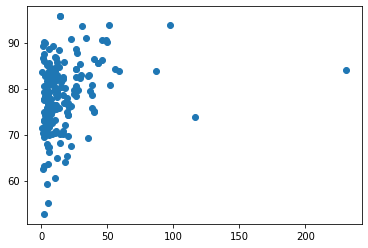

In [18]:
# df_tmp[df_tmp.game_rating_count < 20].game_rating.hist()
plt.scatter(df_tmp[df_tmp.game_rating_count > 20].hltb_main, df_tmp[df_tmp.game_rating_count > 20].game_rating)
plt.show()

In [70]:
json_tmp = json.loads(df_tmp.iloc[2].igdb_json)[0]

print(type(json_tmp))

for json_key in json_tmp.keys():
    print(json_key, " -> ", type(json_tmp[json_key]))
    
for json_genre in json_tmp["genres"]:
    print(igdb_genres[json_genre])
    
result = ((igdb_genres[json_genre] + " ") for json_genre in json_tmp["genres"])

print(str.strip(''.join(result)))

<class 'dict'>
id  ->  <class 'int'>
genres  ->  <class 'list'>
name  ->  <class 'str'>
platforms  ->  <class 'list'>
release_dates  ->  <class 'list'>
summary  ->  <class 'str'>
themes  ->  <class 'list'>
total_rating  ->  <class 'float'>
total_rating_count  ->  <class 'int'>
Shooter
Racing
Adventure
Shooter Racing Adventure
